In [ ]:
import sys
import pandas as pd
from pathlib import Path
project_root = Path("..").resolve()
sys.path.append(str(project_root))
from ml_toolbox import HilbertEnvelopeAnalyzer, EnvelopeConfig, DataLoader, WindowConfig, WindowExtractor


# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

frequency = '20hz'
sensor_type = 'current'
load = 'no_load'
sampling_rate = 10000

healthy, healthy_metadata = data_loader.load_batch(
    condition='healthy', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

# Load faulty data for comparison
faulty_data, faulty_metadata = data_loader.load_batch(
    condition='faulty_bearing', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

n_healthy = 4096
n_faulty = 4096

# Create windows
overlap_ratio = 0.5
healthy_step_size = int(n_healthy * (1 - overlap_ratio))
healthy_window_config = WindowConfig(window_size=n_healthy, 
                             step_size=healthy_step_size,
                             overlap_ratio=overlap_ratio)
healthy_extractor = WindowExtractor(healthy_window_config)
healthy_windows, healthy_win_metadata = healthy_extractor.extract_windows(healthy[0], healthy_metadata[0])

faulty_step_size = int(faulty_data[0].shape[0] * (1 - overlap_ratio))
faulty_window_config = WindowConfig(
    window_size=n_faulty,
    step_size=faulty_step_size,
    overlap_ratio=overlap_ratio
)

faulty_extractor = WindowExtractor(faulty_window_config)
faulty_windows, faulty_win_metadata = faulty_extractor.extract_windows(faulty_data[0], faulty_metadata[0])

h_w = healthy_windows[0]
h_ch1 = h_w[:, 0]
h_ch2 = h_w[:, 1]

f_w = faulty_windows[0]
f_ch1 = f_w[:, 0]
f_ch2 = f_w[:, 1]

# carrier freqs: 1670, 3330
carrier_freq = 3330
env_conf = EnvelopeConfig(
    bandpass_low=carrier_freq - 50,
    bandpass_high=carrier_freq + 50,
    lowpass_cutoff=200.0,
    filter_order=4,
    decimation_factor=5,
    sampling_rate=10000 # current fs
)

analyzer = HilbertEnvelopeAnalyzer(env_conf)

h_stages = analyzer.extract_envelope_with_stages(h_ch1, return_stages=True)
f_stages = analyzer.extract_envelope_with_stages(f_ch1, return_stages=True)




INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files


Healthy - Detected Peaks:
  Peak 1: 9.77 Hz, magnitude: 0.565174
  Peak 2: 1660.16 Hz, magnitude: 0.054453
  Peak 3: 3320.31 Hz, magnitude: 0.032381
  Peak 4: 4833.98 Hz, magnitude: 0.011356
  Peak 5: 4990.23 Hz, magnitude: 1.000000
Faulty - Detected Peaks:
  Peak 1: 9.77 Hz, magnitude: 0.579048
  Peak 2: 1660.16 Hz, magnitude: 0.054992
  Peak 3: 3291.02 Hz, magnitude: 0.017008
  Peak 4: 3349.61 Hz, magnitude: 0.034791
  Peak 5: 4990.23 Hz, magnitude: 1.000000


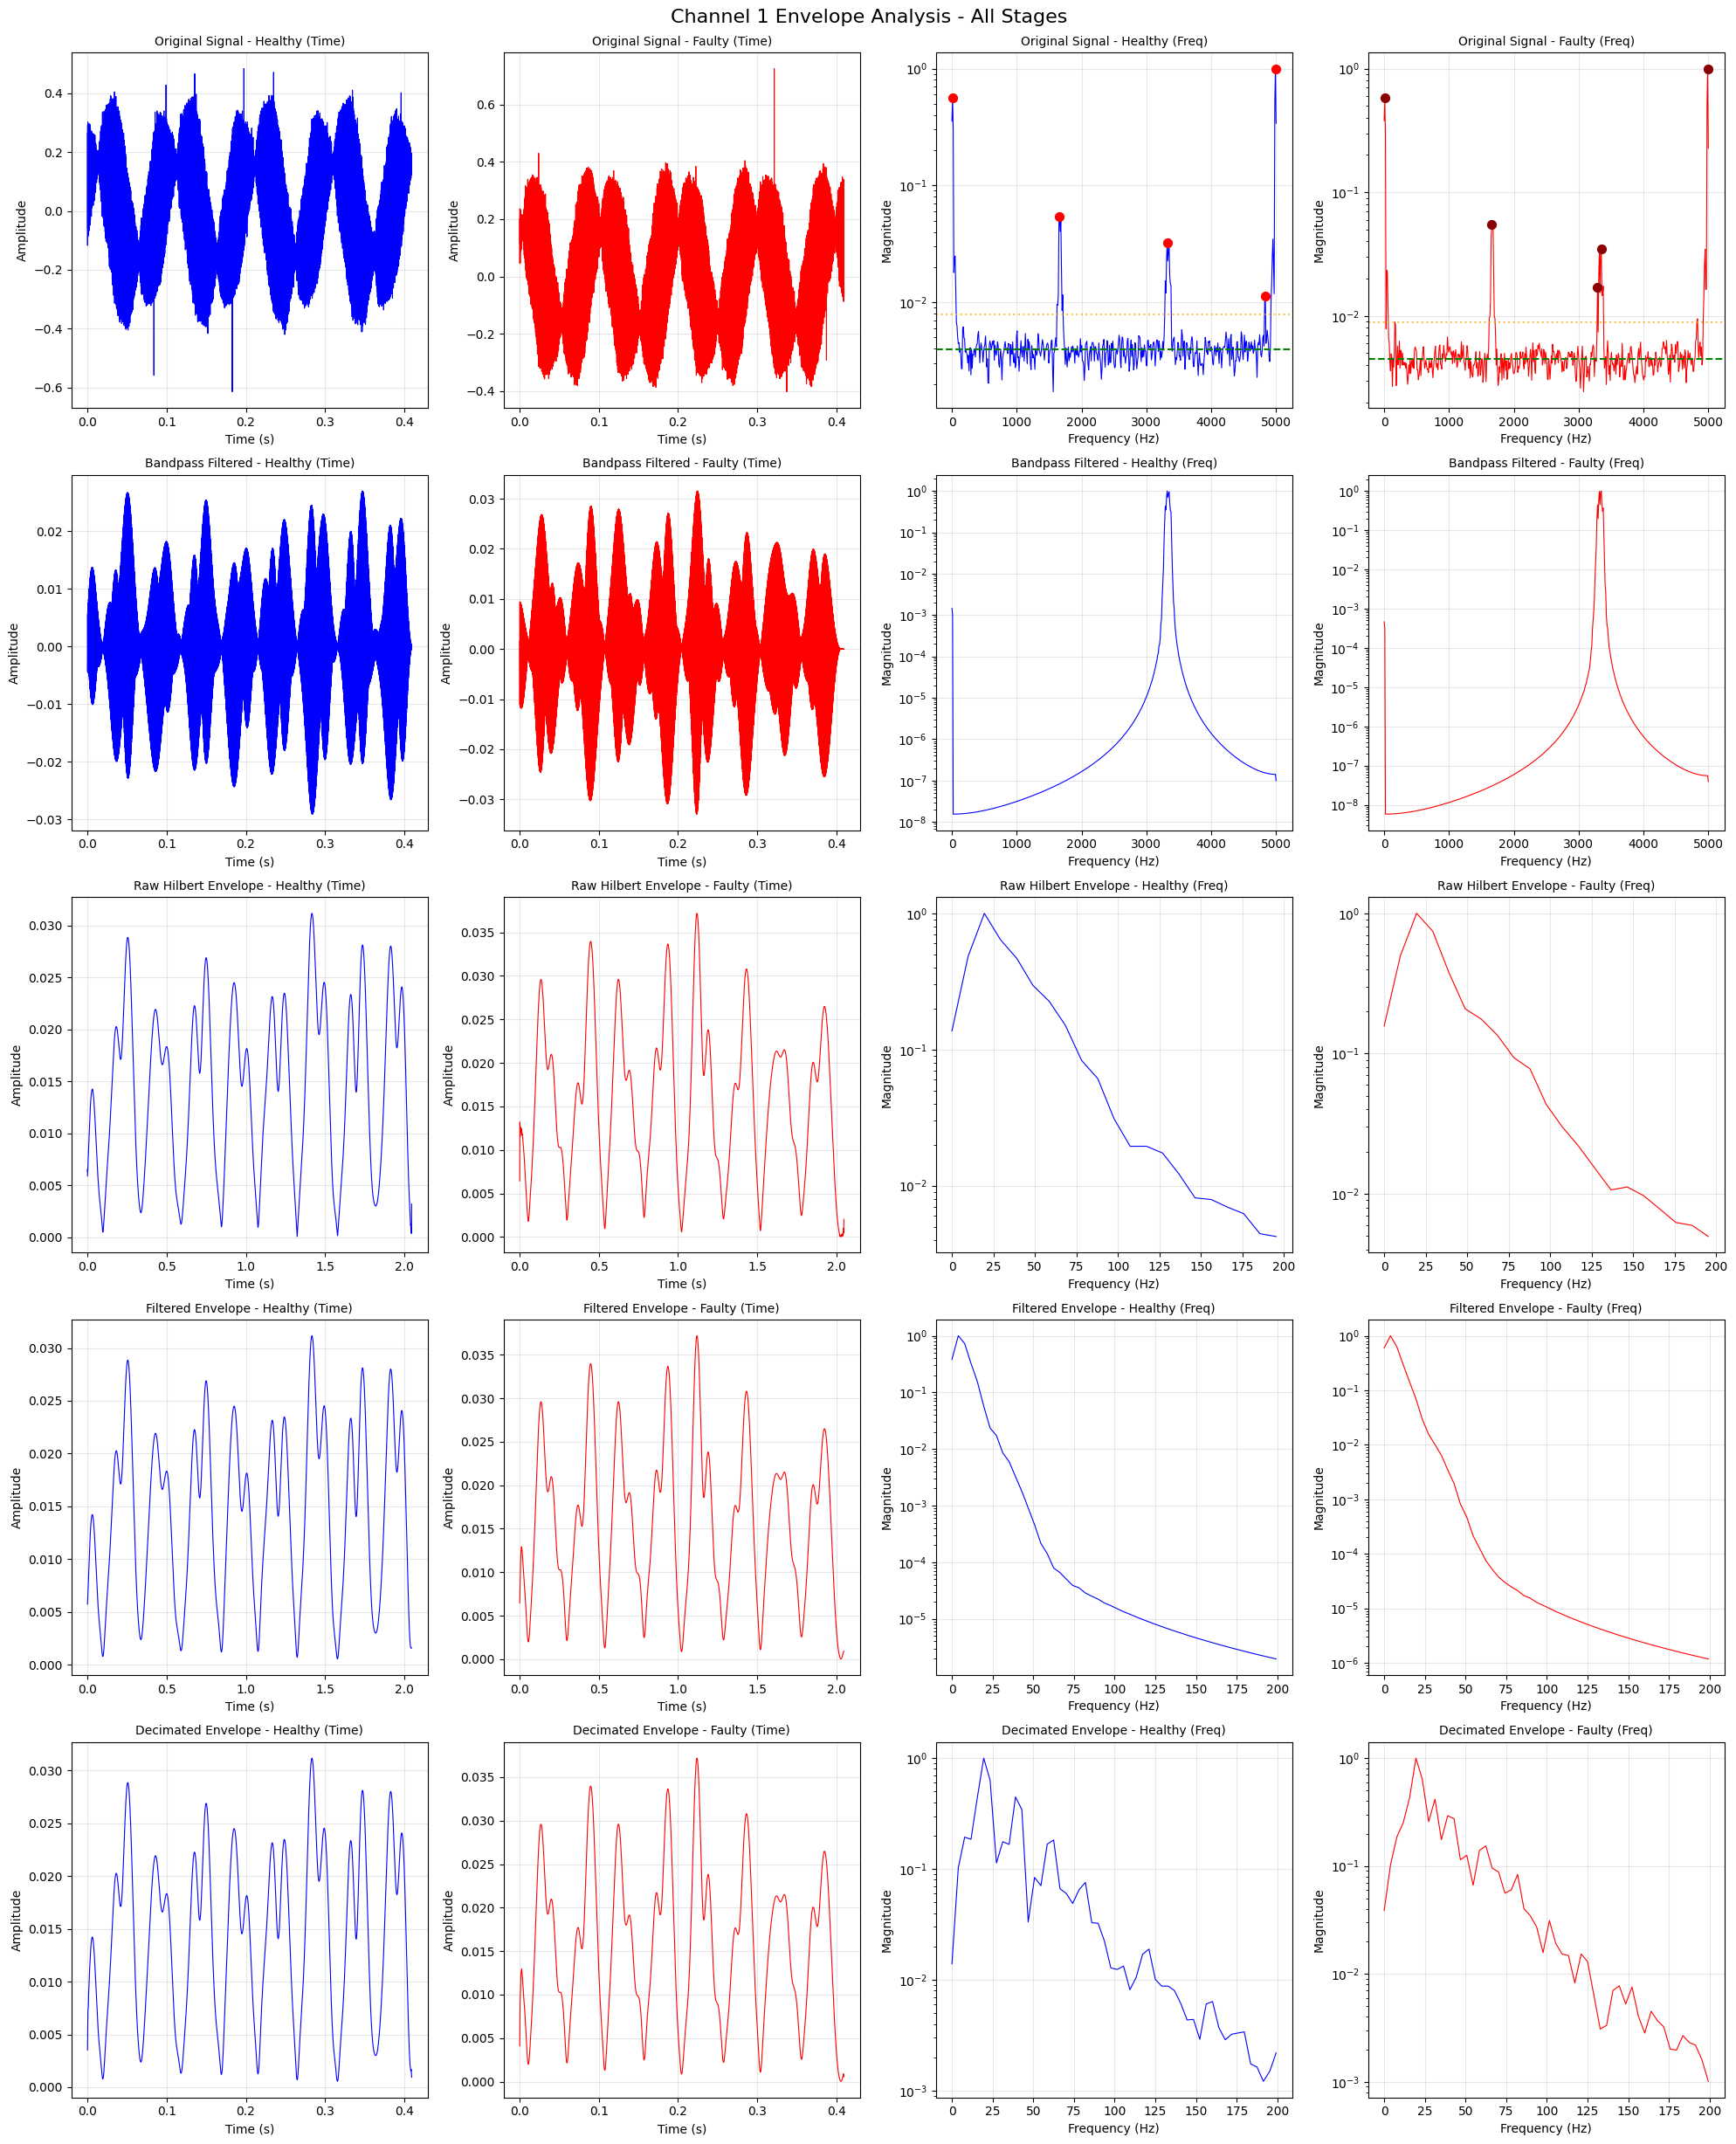

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive plots for all stages
def plot_envelope_analysis(stages_healthy, stages_faulty, analyzer_config, title_prefix=""):
    """Plot all envelope analysis stages in time and frequency domains"""
    
    # Create figure with subplots
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))
    fig.suptitle(f'{title_prefix} Envelope Analysis - All Stages', fontsize=16, y=0.98)
    
    # Stage names and their corresponding data
    stage_names = ['original', 'bandpass_filtered', 'envelope_raw', 'envelope_filtered', 'envelope_decimated']
    stage_titles = ['Original Signal', 'Bandpass Filtered', 'Raw Hilbert Envelope', 'Filtered Envelope', 'Decimated Envelope']
    
    for i, (stage_name, stage_title) in enumerate(zip(stage_names, stage_titles)):
        # Get data for current stage
        h_data = stages_healthy[stage_name]
        f_data = stages_faulty[stage_name]
        
        # Determine sampling rate for this stage
        if 'envelope' in stage_name:
            fs = analyzer_config.envelope_fs
        else:
            fs = analyzer_config.sampling_rate
        
        # Create time vectors
        h_time = np.arange(len(h_data)) / fs
        f_time = np.arange(len(f_data)) / fs
        
        # Time domain plots - Healthy
        axes[i, 0].plot(h_time, h_data, 'b-', linewidth=0.8)
        axes[i, 0].set_title(f'{stage_title} - Healthy (Time)', fontsize=10)
        axes[i, 0].set_xlabel('Time (s)')
        axes[i, 0].set_ylabel('Amplitude')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Time domain plots - Faulty
        axes[i, 1].plot(f_time, f_data, 'r-', linewidth=0.8)
        axes[i, 1].set_title(f'{stage_title} - Faulty (Time)', fontsize=10)
        axes[i, 1].set_xlabel('Time (s)')
        axes[i, 1].set_ylabel('Amplitude')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Frequency domain analysis - Healthy
        nperseg = 512 if stage_name == 'envelope_filtered' or stage_name == 'envelope_decimated' else 1024
        h_spectrum = analyzer.compute_fft_spectrum(stages_healthy['original'], stage_name, nperseg = nperseg)

        h_freqs = h_spectrum['freqs']
        h_magnitude = h_spectrum['magnitude']
        
        # Plot spectrum up to reasonable frequency limit
        freq_limit = min(fs/2, 200) if 'envelope' in stage_name else min(fs/2, 5000)
        freq_mask = h_freqs <= freq_limit
        
        axes[i, 2].plot(h_freqs[freq_mask], h_magnitude[freq_mask], 'b-', linewidth=0.8)
        axes[i, 2].set_title(f'{stage_title} - Healthy (Freq)', fontsize=10)
        axes[i, 2].set_xlabel('Frequency (Hz)')
        axes[i, 2].set_ylabel('Magnitude')
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].set_yscale('log')
        
        # Frequency domain analysis - Faulty
        f_spectrum = analyzer.compute_fft_spectrum(stages_faulty['original'], stage_name, nperseg=nperseg)
        f_freqs = f_spectrum['freqs']
        f_magnitude = f_spectrum['magnitude']
        
        freq_mask_f = f_freqs <= freq_limit
        
        axes[i, 3].plot(f_freqs[freq_mask_f], f_magnitude[freq_mask_f], 'r-', linewidth=0.8)
        axes[i, 3].set_title(f'{stage_title} - Faulty (Freq)', fontsize=10)
        axes[i, 3].set_xlabel('Frequency (Hz)')
        axes[i, 3].set_ylabel('Magnitude')
        axes[i, 3].grid(True, alpha=0.3)
        axes[i, 3].set_yscale('log')

        if stage_name == 'original':
            h_median = np.median(h_magnitude)
            axes[i, 2].axhline(y=h_median, color='g', linestyle='--')
            axes[i, 2].axhline(y=h_median*2, color='orange', linestyle=':', alpha=0.7)
            h_peaks = analyzer.find_spectral_peaks(h_spectrum, num_peaks= 5, distance=5, height=h_median*2, prominence=h_median)
            axes[i, 2].scatter(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'], 
                          color='red', s=50, zorder=5, label='Detected Peaks')
            f_median = np.median(f_magnitude)
            axes[i, 3].axhline(y=f_median, color='g', linestyle='--')
            axes[i, 3].axhline(y=f_median*2, color='orange', linestyle=':', alpha=0.7)
            f_peaks = analyzer.find_spectral_peaks(f_spectrum, num_peaks=5, distance=5, height=f_median*2, prominence=f_median)
            axes[i, 3].scatter(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'],
                               color='darkred', s=50, zorder=5, label='Detected Peaks')
            if len(h_peaks['peak_freqs']) > 0:
                print("Healthy - Detected Peaks:")
                for idx, (freq, mag) in enumerate(zip(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'])):
                    print(f"  Peak {idx+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")

            if len(f_peaks['peak_freqs']) > 0:
                print("Faulty - Detected Peaks:")
                for idx, (freq, mag) in enumerate(zip(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'])):
                    print(f"  Peak {idx+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.96)
    plt.show()
    
    return fig

# Plot the analysis
fig = plot_envelope_analysis(h_stages, f_stages, env_conf, "Channel 1")

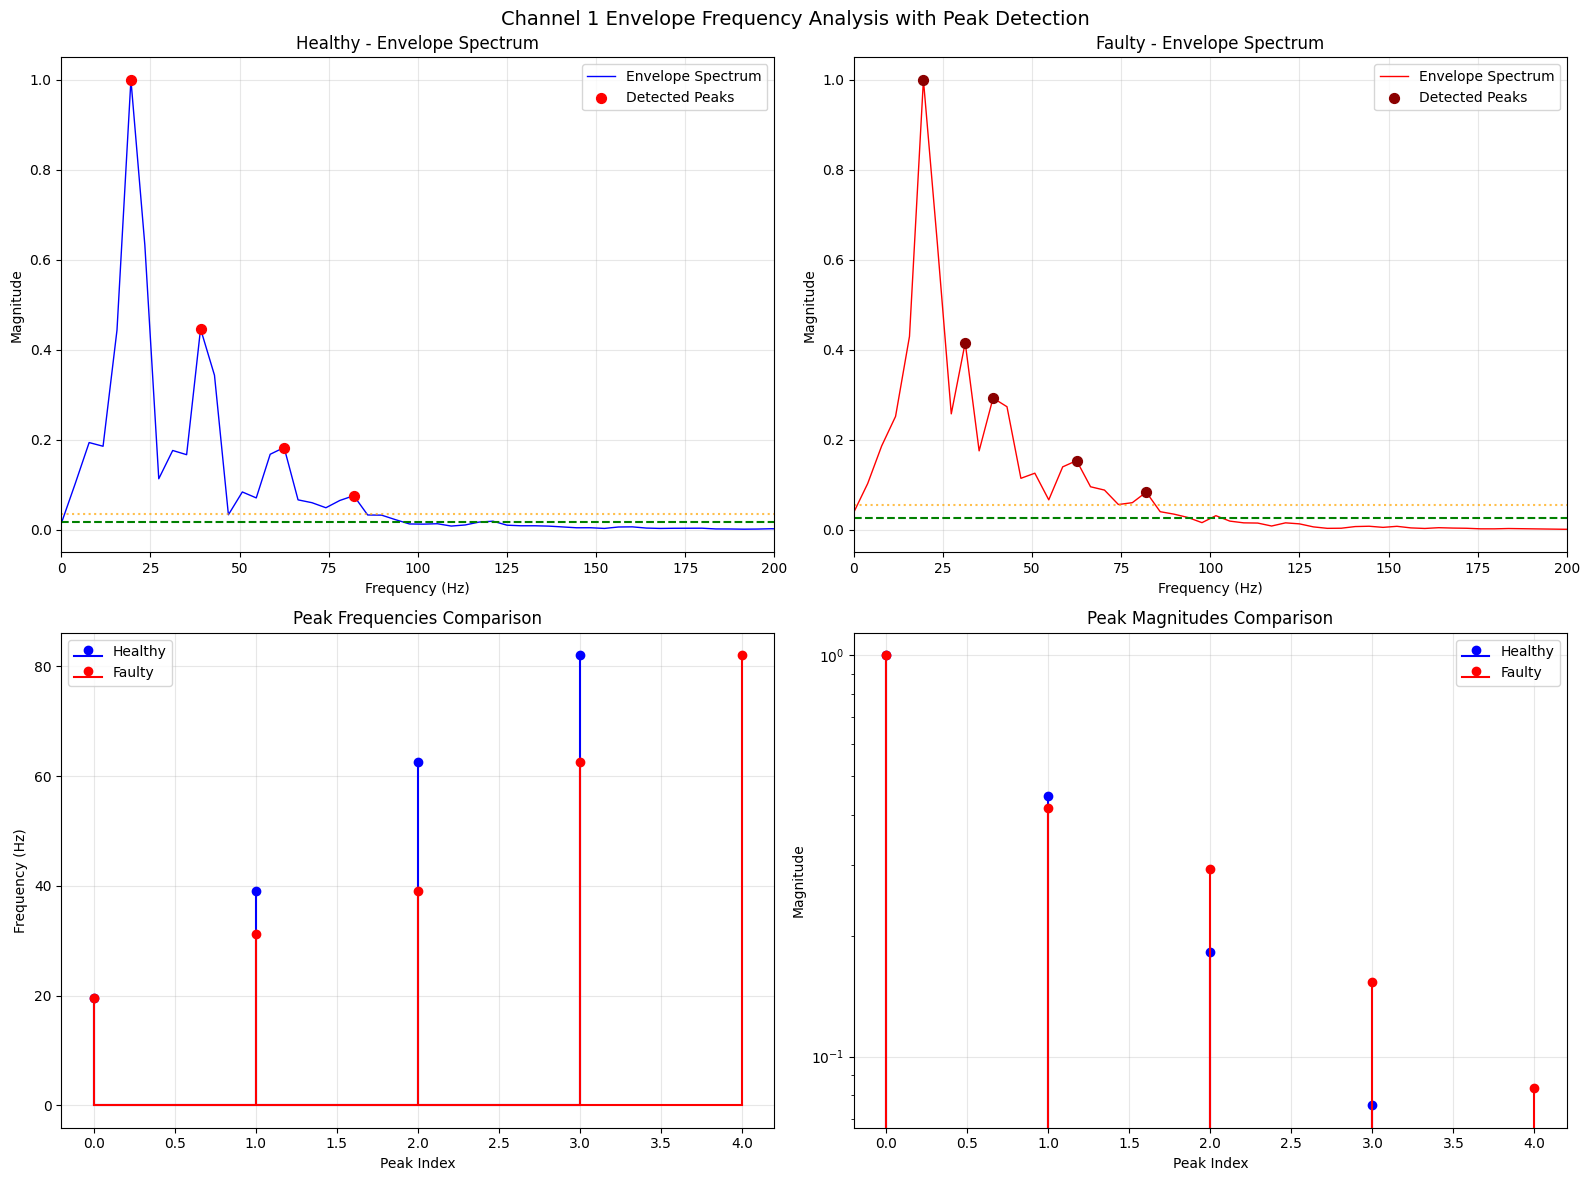


Channel 1 - Peak Analysis:

Healthy Envelope Peaks:
  Peak 1: 19.53 Hz, magnitude: 1.000000
  Peak 2: 39.06 Hz, magnitude: 0.446493
  Peak 3: 62.50 Hz, magnitude: 0.182706
  Peak 4: 82.03 Hz, magnitude: 0.075648

Faulty Envelope Peaks:
  Peak 1: 19.53 Hz, magnitude: 1.000000
  Peak 2: 31.25 Hz, magnitude: 0.415854
  Peak 3: 39.06 Hz, magnitude: 0.292707
  Peak 4: 62.50 Hz, magnitude: 0.153600
  Peak 5: 82.03 Hz, magnitude: 0.083576

Spectrum Statistics:
Healthy - Max magnitude: 1.000000, Mean: 0.019275
Faulty  - Max magnitude: 1.000000, Mean: 0.020854


In [3]:
# Detailed frequency analysis with peak detection
def plot_envelope_frequency_analysis(stages_healthy, stages_faulty, analyzer, title_prefix=""):
    """Detailed frequency analysis of envelope with peak detection"""
    
    # Get envelope spectra
    h_spectrum = analyzer.compute_fft_spectrum(stages_healthy['original'], 'envelope_decimated', nperseg=512)
    f_spectrum = analyzer.compute_fft_spectrum(stages_faulty['original'], 'envelope_decimated', nperseg=512)

    # Find peaks 
    peak_cutoff = 200  # Hz
    cutoff_idx_h = np.where(h_spectrum['freqs'] <= peak_cutoff)[0][-1] if len(np.where(h_spectrum['freqs'] <= peak_cutoff)[0]) > 0 else len(h_spectrum['freqs'])//2
    cutoff_idx_f = np.where(f_spectrum['freqs'] <= peak_cutoff)[0][-1] if len(np.where(f_spectrum['freqs'] <= peak_cutoff)[0]) > 0 else len(f_spectrum['freqs'])//2
    h_median = np.median(h_spectrum['magnitude'][:cutoff_idx_h])
    f_median = np.median(f_spectrum['magnitude'][:cutoff_idx_f])

    h_peaks = analyzer.find_spectral_peaks(h_spectrum, num_peaks=10, distance=2, prominence=h_median, height=h_median*2)
    f_peaks = analyzer.find_spectral_peaks(f_spectrum, num_peaks=10, distance=2, prominence=f_median, height=f_median*2)

    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{title_prefix} Envelope Frequency Analysis with Peak Detection', fontsize=14)
    
    # Healthy envelope spectrum
    axes[0, 0].plot(h_spectrum['freqs'], h_spectrum['magnitude'], 'b-', linewidth=1, label='Envelope Spectrum')
    if len(h_peaks['peak_freqs']) > 0:
        axes[0, 0].scatter(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'], 
                          color='red', s=50, zorder=5, label='Detected Peaks')
    axes[0, 0].set_title('Healthy - Envelope Spectrum')
    axes[0, 0].set_xlabel('Frequency (Hz)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    axes[0, 0].set_xlim(0, 200) 
    axes[0, 0].axhline(y=h_median, color='g', linestyle='--')
    axes[0, 0].axhline(y=h_median*2, color='orange', linestyle=':', alpha=0.7)

    # Faulty envelope spectrum
    axes[0, 1].plot(f_spectrum['freqs'], f_spectrum['magnitude'], 'r-', linewidth=1, label='Envelope Spectrum')
    if len(f_peaks['peak_freqs']) > 0:
        axes[0, 1].scatter(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'], 
                          color='darkred', s=50, zorder=5, label='Detected Peaks')
    axes[0, 1].set_title('Faulty - Envelope Spectrum')
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    axes[0, 1].set_xlim(0, 200)
    axes[0, 1].axhline(y=f_median, color='g', linestyle='--')
    axes[0, 1].axhline(y=f_median*2, color='orange', linestyle=':', alpha=0.7)
    
    # Comparison of peak frequencies - handle case where no peaks found
    if len(h_peaks['peak_freqs']) > 0:
        axes[1, 0].stem(range(len(h_peaks['peak_freqs'])), h_peaks['peak_freqs'], 
                       basefmt='b-', linefmt='b-', markerfmt='bo', label='Healthy')
    if len(f_peaks['peak_freqs']) > 0:
        axes[1, 0].stem(range(len(f_peaks['peak_freqs'])), f_peaks['peak_freqs'], 
                       basefmt='r-', linefmt='r-', markerfmt='ro', label='Faulty')
    
    if len(h_peaks['peak_freqs']) == 0 and len(f_peaks['peak_freqs']) == 0:
        axes[1, 0].text(0.5, 0.5, 'No peaks detected', ha='center', va='center', 
                       transform=axes[1, 0].transAxes, fontsize=12)
    
    axes[1, 0].set_title('Peak Frequencies Comparison')
    axes[1, 0].set_xlabel('Peak Index')
    axes[1, 0].set_ylabel('Frequency (Hz)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Comparison of peak magnitudes - handle case where no peaks found
    if len(h_peaks['peak_magnitudes']) > 0:
        axes[1, 1].stem(range(len(h_peaks['peak_magnitudes'])), h_peaks['peak_magnitudes'], 
                       basefmt='b-', linefmt='b-', markerfmt='bo', label='Healthy')
    if len(f_peaks['peak_magnitudes']) > 0:
        axes[1, 1].stem(range(len(f_peaks['peak_magnitudes'])), f_peaks['peak_magnitudes'], 
                       basefmt='r-', linefmt='r-', markerfmt='ro', label='Faulty')
    
    if len(h_peaks['peak_magnitudes']) == 0 and len(f_peaks['peak_magnitudes']) == 0:
        axes[1, 1].text(0.5, 0.5, 'No peaks detected', ha='center', va='center', 
                       transform=axes[1, 1].transAxes, fontsize=12)
    else:
        axes[1, 1].set_yscale('log')
    
    axes[1, 1].set_title('Peak Magnitudes Comparison')
    axes[1, 1].set_xlabel('Peak Index')
    axes[1, 1].set_ylabel('Magnitude')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print peak information
    print(f"\n{title_prefix} - Peak Analysis:")
    print("="*50)
    
    if len(h_peaks['peak_freqs']) > 0:
        print("\nHealthy Envelope Peaks:")
        for i, (freq, mag) in enumerate(zip(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'])):
            print(f"  Peak {i+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")
    else:
        print("\nHealthy Envelope: No peaks detected with current parameters")
    
    if len(f_peaks['peak_freqs']) > 0:
        print("\nFaulty Envelope Peaks:")
        for i, (freq, mag) in enumerate(zip(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'])):
            print(f"  Peak {i+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")
    else:
        print("\nFaulty Envelope: No peaks detected with current parameters")
    
    # Print some spectrum statistics
    print(f"\nSpectrum Statistics:")
    print(f"Healthy - Max magnitude: {np.max(h_spectrum['magnitude']):.6f}, Mean: {np.mean(h_spectrum['magnitude']):.6f}")
    print(f"Faulty  - Max magnitude: {np.max(f_spectrum['magnitude']):.6f}, Mean: {np.mean(f_spectrum['magnitude']):.6f}")
    
    return fig, {'spectrum': h_spectrum, 'peaks': h_peaks}, {'spectrum': f_spectrum, 'peaks': f_peaks}

# Run the detailed frequency analysis
fig_freq, h_analysis, f_analysis = plot_envelope_frequency_analysis(h_stages, f_stages, analyzer, "Channel 1")


Channel 1 - Envelope Analysis Summary

Metric          Healthy      Faulty       Ratio (F/H)  Diff %    
----------------------------------------------------------------------
RMS             0.016533     0.017935     1.08         8.5       %
Peak            0.031167     0.037182     1.19         19.3      %
Mean            0.014459     0.015605     1.08         7.9       %
Std             0.008016     0.008841     1.10         10.3      %
Crest Factor    1.885210     2.073156     1.10         10.0      %
Kurtosis        -1.127419    -0.771095    0.68         -31.6     %
Skewness        -0.095360    0.187950     -1.97        -297.1    %


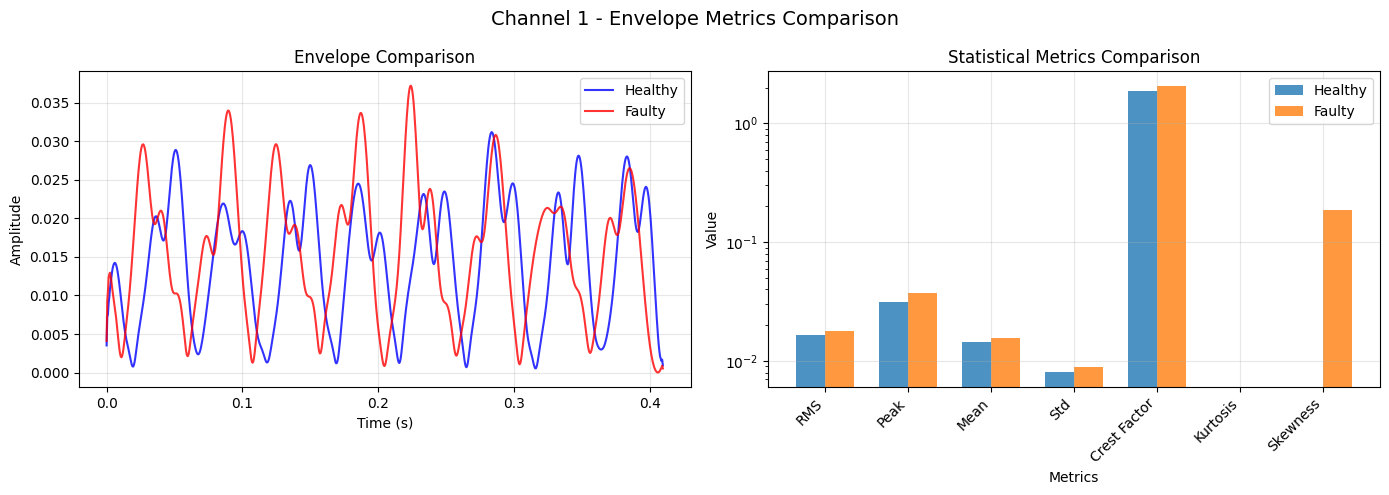

In [4]:
# Summary analysis and metrics comparison
def analyze_envelope_metrics(stages_healthy, stages_faulty, analyzer, title_prefix=""):
    """Calculate and compare envelope metrics between healthy and faulty signals"""
    
    print(f"\n{title_prefix} - Envelope Analysis Summary")
    print("="*60)
    
    # Extract final envelopes
    h_envelope = stages_healthy['envelope_decimated']
    f_envelope = stages_faulty['envelope_decimated']
    
    # Basic statistical metrics
    h_metrics = {
        'RMS': np.sqrt(np.mean(h_envelope**2)),
        'Peak': np.max(h_envelope),
        'Mean': np.mean(h_envelope),
        'Std': np.std(h_envelope),
        'Crest Factor': np.max(h_envelope) / np.sqrt(np.mean(h_envelope**2)),
        'Kurtosis': np.mean(((h_envelope - np.mean(h_envelope)) / np.std(h_envelope))**4) - 3,
        'Skewness': np.mean(((h_envelope - np.mean(h_envelope)) / np.std(h_envelope))**3)
    }
    
    f_metrics = {
        'RMS': np.sqrt(np.mean(f_envelope**2)),
        'Peak': np.max(f_envelope),
        'Mean': np.mean(f_envelope),
        'Std': np.std(f_envelope),
        'Crest Factor': np.max(f_envelope) / np.sqrt(np.mean(f_envelope**2)),
        'Kurtosis': np.mean(((f_envelope - np.mean(f_envelope)) / np.std(f_envelope))**4) - 3,
        'Skewness': np.mean(((f_envelope - np.mean(f_envelope)) / np.std(f_envelope))**3)
    }
    
    # Print comparison table
    print(f"\n{'Metric':<15} {'Healthy':<12} {'Faulty':<12} {'Ratio (F/H)':<12} {'Diff %':<10}")
    print("-" * 70)
    
    for metric in h_metrics.keys():
        h_val = h_metrics[metric]
        f_val = f_metrics[metric]
        ratio = f_val / h_val if h_val != 0 else float('inf')
        diff_pct = ((f_val - h_val) / h_val * 100) if h_val != 0 else float('inf')
        
        print(f"{metric:<15} {h_val:<12.6f} {f_val:<12.6f} {ratio:<12.2f} {diff_pct:<10.1f}%")
    
    # Create comparison visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{title_prefix} - Envelope Metrics Comparison', fontsize=14)
    
    # Envelope comparison
    time_h = np.arange(len(h_envelope)) / analyzer.config.envelope_fs
    time_f = np.arange(len(f_envelope)) / analyzer.config.envelope_fs
    
    axes[0].plot(time_h, h_envelope, 'b-', label='Healthy', alpha=0.8)
    axes[0].plot(time_f, f_envelope, 'r-', label='Faulty', alpha=0.8)
    axes[0].set_title('Envelope Comparison')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Statistical metrics comparison
    metrics_names = list(h_metrics.keys())
    h_values = list(h_metrics.values())
    f_values = list(f_metrics.values())
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    axes[1].bar(x - width/2, h_values, width, label='Healthy', alpha=0.8)
    axes[1].bar(x + width/2, f_values, width, label='Faulty', alpha=0.8)
    axes[1].set_title('Statistical Metrics Comparison')
    axes[1].set_xlabel('Metrics')
    axes[1].set_ylabel('Value')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(metrics_names, rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return h_metrics, f_metrics, 

# Run comprehensive analysis
h_metrics, f_metrics= analyze_envelope_metrics(h_stages, f_stages, analyzer, "Channel 1")

In [ ]:
# PDF Report Generation for All Windows
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
from datetime import datetime

def create_comprehensive_pdf_report(healthy_windows, faulty_windows, analyzer, config, 
                                   output_filename="envelope_analysis_report.pdf"):
    """
    Create a comprehensive PDF report with plots and statistics for all healthy and faulty windows
    Reuses existing analysis functions from the notebook
    """
    
    # Limit to first 10 windows of each type for manageable PDF size
    max_windows = 10
    healthy_subset = healthy_windows[:max_windows]
    faulty_subset = faulty_windows[:max_windows]
    
    print(f"Creating comprehensive PDF report with {len(healthy_subset)} healthy and {len(faulty_subset)} faulty windows...")
    print("Using your existing analysis functions!")
    
    with PdfPages(output_filename) as pdf:
        # Title page
        create_title_page(pdf, len(healthy_subset), len(faulty_subset), config)
        
        # Comparative analysis using your existing functions with ALL data
        create_comparative_analysis_page(pdf, healthy_subset, faulty_subset, analyzer)
        
    print(f"PDF report saved as: {output_filename}")
    return output_filename

def create_title_page(pdf, n_healthy, n_faulty, config):
    """Create title page for the PDF report"""
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.axis('off')
    
    # Title
    ax.text(0.5, 0.9, 'Motor Health Envelope Analysis Report', 
            fontsize=24, fontweight='bold', ha='center', transform=ax.transAxes)
    
    # Subtitle
    ax.text(0.5, 0.85, 'Comprehensive Analysis of Healthy vs Faulty Motor Signals', 
            fontsize=16, ha='center', transform=ax.transAxes)
    
    # Report details
    report_info = f"""
    Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    
    Analysis Parameters:
    • Carrier Frequency: {config.bandpass_low + 50} Hz
    • Bandpass Filter: {config.bandpass_low} - {config.bandpass_high} Hz
    • Lowpass Cutoff: {config.lowpass_cutoff} Hz
    • Sampling Rate: {config.sampling_rate} Hz
    • Decimation Factor: {config.decimation_factor}
    
    Dataset Summary:
    • Healthy Windows: {n_healthy}
    • Faulty Windows: {n_faulty}
    • Total Windows: {n_healthy + n_faulty}
    """
    
    ax.text(0.1, 0.6, report_info, fontsize=12, transform=ax.transAxes, 
            verticalalignment='top', family='monospace')
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

def create_summary_statistics_page(pdf, healthy_windows, faulty_windows, analyzer):
    """Create summary statistics page comparing all windows"""
    fig, axes = plt.subplots(2, 2, figsize=(11, 8.5))
    fig.suptitle('Summary Statistics - All Windows Comparison', fontsize=16, fontweight='bold')
    
    # Calculate statistics for all windows
    h_all_metrics = []
    f_all_metrics = []
    
    for window in healthy_windows:
        stages = analyzer.extract_envelope_with_stages(window[:, 0], return_stages=True)
        envelope = stages['envelope_decimated']
        metrics = calculate_envelope_metrics(envelope)
        h_all_metrics.append(metrics)
    
    for window in faulty_windows:
        stages = analyzer.extract_envelope_with_stages(window[:, 0], return_stages=True)
        envelope = stages['envelope_decimated']
        metrics = calculate_envelope_metrics(envelope)
        f_all_metrics.append(metrics)
    
    # Convert to DataFrames
    h_df = pd.DataFrame(h_all_metrics)
    f_df = pd.DataFrame(f_all_metrics)
    
    # Box plots for key metrics
    metrics_to_plot = ['RMS', 'Peak', 'Crest_Factor', 'Kurtosis']
    
    for i, metric in enumerate(metrics_to_plot):
        row = i // 2
        col = i % 2
        
        data_to_plot = [h_df[metric].values, f_df[metric].values]
        box_plot = axes[row, col].boxplot(data_to_plot, labels=['Healthy', 'Faulty'], patch_artist=True)
        
        # Color the boxes
        box_plot['boxes'][0].set_facecolor('lightblue')
        box_plot['boxes'][1].set_facecolor('lightcoral')
        
        axes[row, col].set_title(f'{metric} Distribution')
        axes[row, col].set_ylabel('Value')
        axes[row, col].grid(True, alpha=0.3)
        
        if metric in ['RMS', 'Peak']:
            axes[row, col].set_yscale('log')
    
    # Add statistics table
    stats_text = create_statistics_summary_table(h_df, f_df)
    fig.text(0.1, 0.02, stats_text, fontsize=8, family='monospace')
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

def create_window_analysis_page(pdf, window, analyzer, title, condition):
    """Create analysis page for a single window using existing functions"""
    
    # Extract envelope stages for the current window
    stages = analyzer.extract_envelope_with_stages(window[:, 0], return_stages=True)
    
    # For individual window analysis, we'll create a simplified version
    # that shows just this one window's analysis instead of comparison
    # For individual window analysis, we'll create a simplified version
    # that shows just this one window's analysis instead of comparison
    
    # Create a simple single-window analysis plot
    plt.ioff()  # Turn off interactive mode for PDF
    
    fig, axes = plt.subplots(3, 2, figsize=(11, 8.5))
    fig.suptitle(f'{title} - Envelope Analysis', fontsize=14, fontweight='bold')
    
    # Time domain plots
    fs = analyzer.config.sampling_rate
    envelope_fs = analyzer.config.envelope_fs
    
    # Original signal
    time_orig = np.arange(len(stages['original'])) / fs
    color = 'b-' if condition == 'healthy' else 'r-'
    
    axes[0, 0].plot(time_orig, stages['original'], color, linewidth=0.8)
    axes[0, 0].set_title('Original Signal')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Bandpass filtered signal
    axes[0, 1].plot(time_orig, stages['bandpass_filtered'], color, linewidth=0.8)
    axes[0, 1].set_title('Bandpass Filtered Signal')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Amplitude')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Envelope signals - use correct time vectors for each stage
    time_env_filtered = np.arange(len(stages['envelope_filtered'])) / analyzer.config.sampling_rate
    time_env_decimated = np.arange(len(stages['envelope_decimated'])) / envelope_fs
    
    axes[1, 0].plot(time_env_filtered, stages['envelope_filtered'], color, linewidth=0.8)
    axes[1, 0].set_title('Filtered Envelope')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(time_env_decimated, stages['envelope_decimated'], color, linewidth=0.8)
    axes[1, 1].set_title('Final Envelope (Decimated)')
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_ylabel('Amplitude')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Frequency domain analysis
    spectrum = analyzer.compute_fft_spectrum(stages['original'], 'envelope_decimated', nperseg=512)
    
    # Original signal spectrum
    orig_spectrum = analyzer.compute_fft_spectrum(stages['original'], 'original', nperseg=1024)
    freq_limit = min(orig_spectrum['freqs'][-1], 5000)
    freq_mask = orig_spectrum['freqs'] <= freq_limit
    
    axes[2, 0].plot(orig_spectrum['freqs'][freq_mask], orig_spectrum['magnitude'][freq_mask], 
                   color, linewidth=0.8)
    axes[2, 0].set_title('Original Signal Spectrum')
    axes[2, 0].set_xlabel('Frequency (Hz)')
    axes[2, 0].set_ylabel('Magnitude')
    axes[2, 0].set_yscale('log')
    axes[2, 0].grid(True, alpha=0.3)
    
    # Envelope spectrum
    env_freq_limit = min(spectrum['freqs'][-1], 200)
    env_freq_mask = spectrum['freqs'] <= env_freq_limit
    
    axes[2, 1].plot(spectrum['freqs'][env_freq_mask], spectrum['magnitude'][env_freq_mask], 
                   color, linewidth=0.8)
    axes[2, 1].set_title('Envelope Spectrum')
    axes[2, 1].set_xlabel('Frequency (Hz)')
    axes[2, 1].set_ylabel('Magnitude')
    axes[2, 1].set_yscale('log')
    axes[2, 1].grid(True, alpha=0.3)
    
    # Add peak detection
    median_mag = np.median(spectrum['magnitude'][env_freq_mask])
    peaks = analyzer.find_spectral_peaks(spectrum, num_peaks=5, distance=2, 
                                       prominence=median_mag, height=median_mag*2)
    
    if len(peaks['peak_freqs']) > 0:
        axes[2, 1].scatter(peaks['peak_freqs'], peaks['peak_magnitudes'], 
                          color='red', s=50, zorder=5, label='Detected Peaks')
        axes[2, 1].legend()
    
    # Add metrics text
    envelope = stages['envelope_decimated']
    metrics = {
        'RMS': np.sqrt(np.mean(envelope**2)),
        'Peak': np.max(envelope),
        'Mean': np.mean(envelope),
        'Std': np.std(envelope),
        'Crest_Factor': np.max(envelope) / np.sqrt(np.mean(envelope**2)) if np.mean(envelope**2) > 0 else 0,
        'Kurtosis': np.mean(((envelope - np.mean(envelope)) / np.std(envelope))**4) - 3 if np.std(envelope) > 0 else 0,
    }
    
    metrics_text = f"Envelope Metrics ({condition}):\n" + "-" * 25 + "\n"
    for key, value in metrics.items():
        metrics_text += f"{key}: {value:.6f}\n"
    
    fig.text(0.02, 0.02, metrics_text, fontsize=8, family='monospace')
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)
    
    plt.ion()  # Turn interactive mode back on

def create_comparative_analysis_page(pdf, healthy_windows, faulty_windows, analyzer):
    """Create comparative analysis page using existing functions with ALL healthy vs ALL faulty data"""
    
    print(f"Creating comparative analysis with {len(healthy_windows)} healthy and {len(faulty_windows)} faulty windows...")
    
    # Use multiple representative windows for better comparison
    num_comparisons = min(3, len(healthy_windows), len(faulty_windows))  # Compare up to 3 pairs
    
    for i in range(num_comparisons):
        print(f"Processing comparison {i+1}/{num_comparisons}")
        
        # Extract stages for REAL comparison - healthy vs faulty data
        h_stages = analyzer.extract_envelope_with_stages(healthy_windows[i][:, 0], return_stages=True)
        f_stages = analyzer.extract_envelope_with_stages(faulty_windows[i][:, 0], return_stages=True)
        
        plt.ioff()  # Turn off interactive mode for PDF
        
        # Use your existing plot_envelope_analysis function for REAL comparison
        fig1 = plot_envelope_analysis(h_stages, f_stages, analyzer.config, f"Comparison {i+1}: Healthy vs Faulty")
        pdf.savefig(fig1, bbox_inches='tight')
        plt.close(fig1)
        
        # Use your existing plot_envelope_frequency_analysis function for REAL comparison
        fig2, h_analysis, f_analysis = plot_envelope_frequency_analysis(h_stages, f_stages, analyzer, f"Comparison {i+1}: Healthy vs Faulty")
        pdf.savefig(fig2, bbox_inches='tight')
        plt.close(fig2)
        
        # Use your existing analyze_envelope_metrics function for REAL comparison
        import io
        import sys
        
        # Capture stdout to get the printed analysis
        captured_output = io.StringIO()
        sys.stdout = captured_output
        
        try:
            h_metrics, f_metrics = analyze_envelope_metrics(h_stages, f_stages, analyzer, f"Comparison {i+1}: Healthy vs Faulty")
            
            # Restore stdout
            sys.stdout = sys.__stdout__
            
            # Get the captured text
            analysis_text = captured_output.getvalue()
            
            # Create a text page with the analysis results
            fig_text, ax = plt.subplots(figsize=(8.5, 11))
            ax.axis('off')
            ax.text(0.05, 0.95, analysis_text, fontsize=10, family='monospace', 
                    transform=ax.transAxes, verticalalignment='top')
            
            pdf.savefig(fig_text, bbox_inches='tight')
            plt.close(fig_text)
            
        except Exception as e:
            # Restore stdout in case of error
            sys.stdout = sys.__stdout__
            print(f"Error in comparative metrics analysis: {e}")
        
        plt.ion()  # Turn interactive mode back on
    
    # Summary statistics across ALL windows
    create_summary_statistics_all_windows(pdf, healthy_windows, faulty_windows, analyzer)

def create_summary_statistics_all_windows(pdf, healthy_windows, faulty_windows, analyzer):
    """Create summary statistics across all windows"""
    fig, axes = plt.subplots(2, 2, figsize=(11, 8.5))
    fig.suptitle('Summary Statistics - All Windows', fontsize=16, fontweight='bold')
    
    # Calculate metrics for all windows
    h_metrics_list = []
    f_metrics_list = []
    
    for i, window in enumerate(healthy_windows):
        print(f"Processing healthy window {i+1}/{len(healthy_windows)} for summary...")
        stages = analyzer.extract_envelope_with_stages(window[:, 0], return_stages=True)
        envelope = stages['envelope_decimated']
        
        metrics = {
            'RMS': np.sqrt(np.mean(envelope**2)),
            'Peak': np.max(envelope),
            'Mean': np.mean(envelope),
            'Std': np.std(envelope),
            'Crest_Factor': np.max(envelope) / np.sqrt(np.mean(envelope**2)) if np.mean(envelope**2) > 0 else 0,
            'Kurtosis': np.mean(((envelope - np.mean(envelope)) / np.std(envelope))**4) - 3 if np.std(envelope) > 0 else 0,
        }
        h_metrics_list.append(metrics)
    
    for i, window in enumerate(faulty_windows):
        print(f"Processing faulty window {i+1}/{len(faulty_windows)} for summary...")
        stages = analyzer.extract_envelope_with_stages(window[:, 0], return_stages=True)
        envelope = stages['envelope_decimated']
        
        metrics = {
            'RMS': np.sqrt(np.mean(envelope**2)),
            'Peak': np.max(envelope),
            'Mean': np.mean(envelope),
            'Std': np.std(envelope),
            'Crest_Factor': np.max(envelope) / np.sqrt(np.mean(envelope**2)) if np.mean(envelope**2) > 0 else 0,
            'Kurtosis': np.mean(((envelope - np.mean(envelope)) / np.std(envelope))**4) - 3 if np.std(envelope) > 0 else 0,
        }
        f_metrics_list.append(metrics)
    
    # Convert to DataFrames
    h_df = pd.DataFrame(h_metrics_list)
    f_df = pd.DataFrame(f_metrics_list)
    
    # Box plots for key metrics
    metrics_to_plot = ['RMS', 'Peak', 'Crest_Factor', 'Kurtosis']
    
    for i, metric in enumerate(metrics_to_plot):
        row = i // 2
        col = i % 2
        
        data_to_plot = [h_df[metric].values, f_df[metric].values]
        box_plot = axes[row, col].boxplot(data_to_plot, labels=['Healthy', 'Faulty'], patch_artist=True)
        
        # Color the boxes
        box_plot['boxes'][0].set_facecolor('lightblue')
        box_plot['boxes'][1].set_facecolor('lightcoral')
        
        axes[row, col].set_title(f'{metric} Distribution')
        axes[row, col].set_ylabel('Value')
        axes[row, col].grid(True, alpha=0.3)
        
        if metric in ['RMS', 'Peak']:
            axes[row, col].set_yscale('log')
    
    # Add statistics table
    stats_text = create_statistics_summary_table(h_df, f_df)
    fig.text(0.02, 0.02, stats_text, fontsize=8, family='monospace')
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

def calculate_envelope_metrics(envelope):
    """Calculate comprehensive metrics for an envelope signal - simplified version"""
    return {
        'RMS': np.sqrt(np.mean(envelope**2)),
        'Peak': np.max(envelope),
        'Mean': np.mean(envelope),
        'Std': np.std(envelope),
        'Crest_Factor': np.max(envelope) / np.sqrt(np.mean(envelope**2)) if np.mean(envelope**2) > 0 else 0,
        'Kurtosis': np.mean(((envelope - np.mean(envelope)) / np.std(envelope))**4) - 3 if np.std(envelope) > 0 else 0,
    }

def create_statistics_summary_table(h_df, f_df):
    """Create summary statistics table"""
    text = "Summary Statistics (Mean ± Std):\n"
    text += "-" * 50 + "\n"
    text += f"{'Metric':<15} {'Healthy':<15} {'Faulty':<15}\n"
    text += "-" * 50 + "\n"
    
    for metric in h_df.columns:
        h_mean = h_df[metric].mean()
        h_std = h_df[metric].std()
        f_mean = f_df[metric].mean()
        f_std = f_df[metric].std()
        
        text += f"{metric:<15} {h_mean:.3f}±{h_std:.3f}   {f_mean:.3f}±{f_std:.3f}\n"
    
    return text

print("PDF report generation functions updated to use your existing functions!")

PDF report generation functions updated to use your existing functions!


Starting PDF report generation...
Number of healthy windows: 52
Number of faulty windows: 81
Output file: ../notebooks/test_output\envelope_analysis_report_20251009_202412.pdf
Creating comprehensive PDF report with 10 healthy and 10 faulty windows...
Using your existing analysis functions!
Processing healthy window 1/10
Processing healthy window 2/10
Processing healthy window 2/10
Processing healthy window 3/10
Processing healthy window 3/10
Processing healthy window 4/10
Processing healthy window 4/10
Processing healthy window 5/10
Processing healthy window 5/10
Processing healthy window 6/10
Processing healthy window 6/10
Processing healthy window 7/10
Processing healthy window 7/10
Processing healthy window 8/10
Processing healthy window 8/10
Processing healthy window 9/10
Processing healthy window 9/10
Processing healthy window 10/10
Processing healthy window 10/10
Processing faulty window 1/10
Processing faulty window 1/10
Processing faulty window 2/10
Processing faulty window 2/1

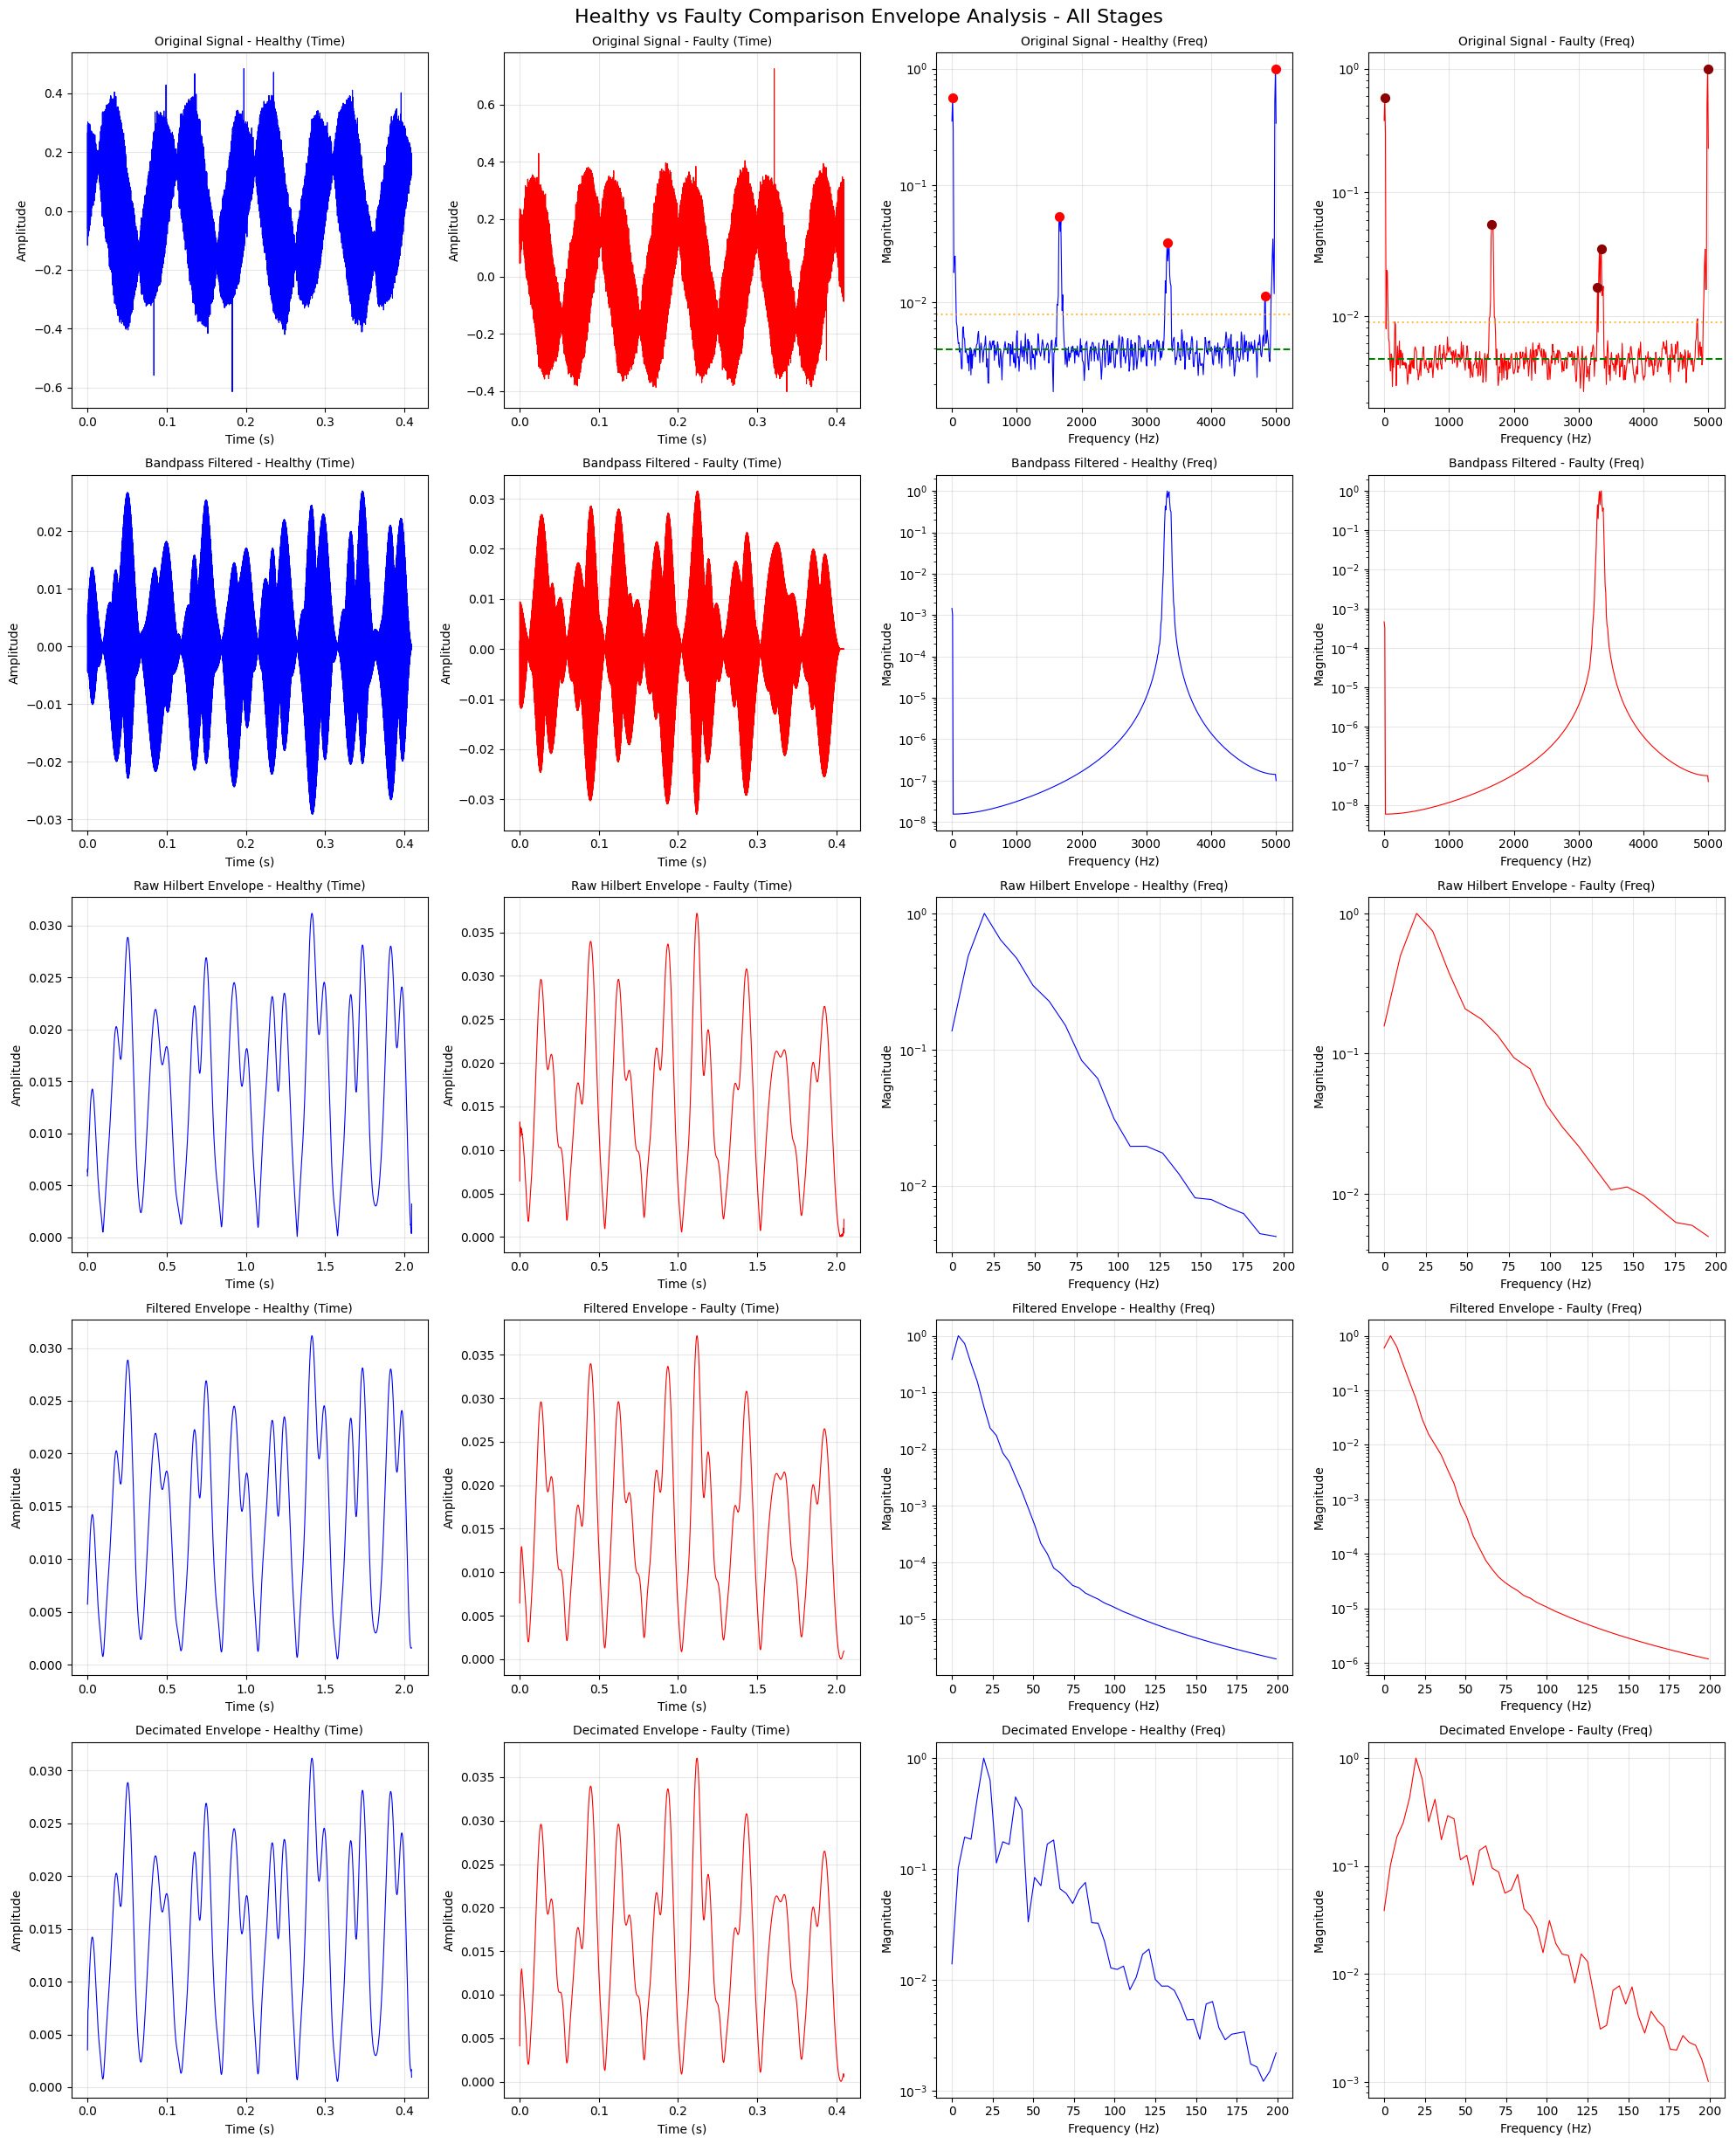

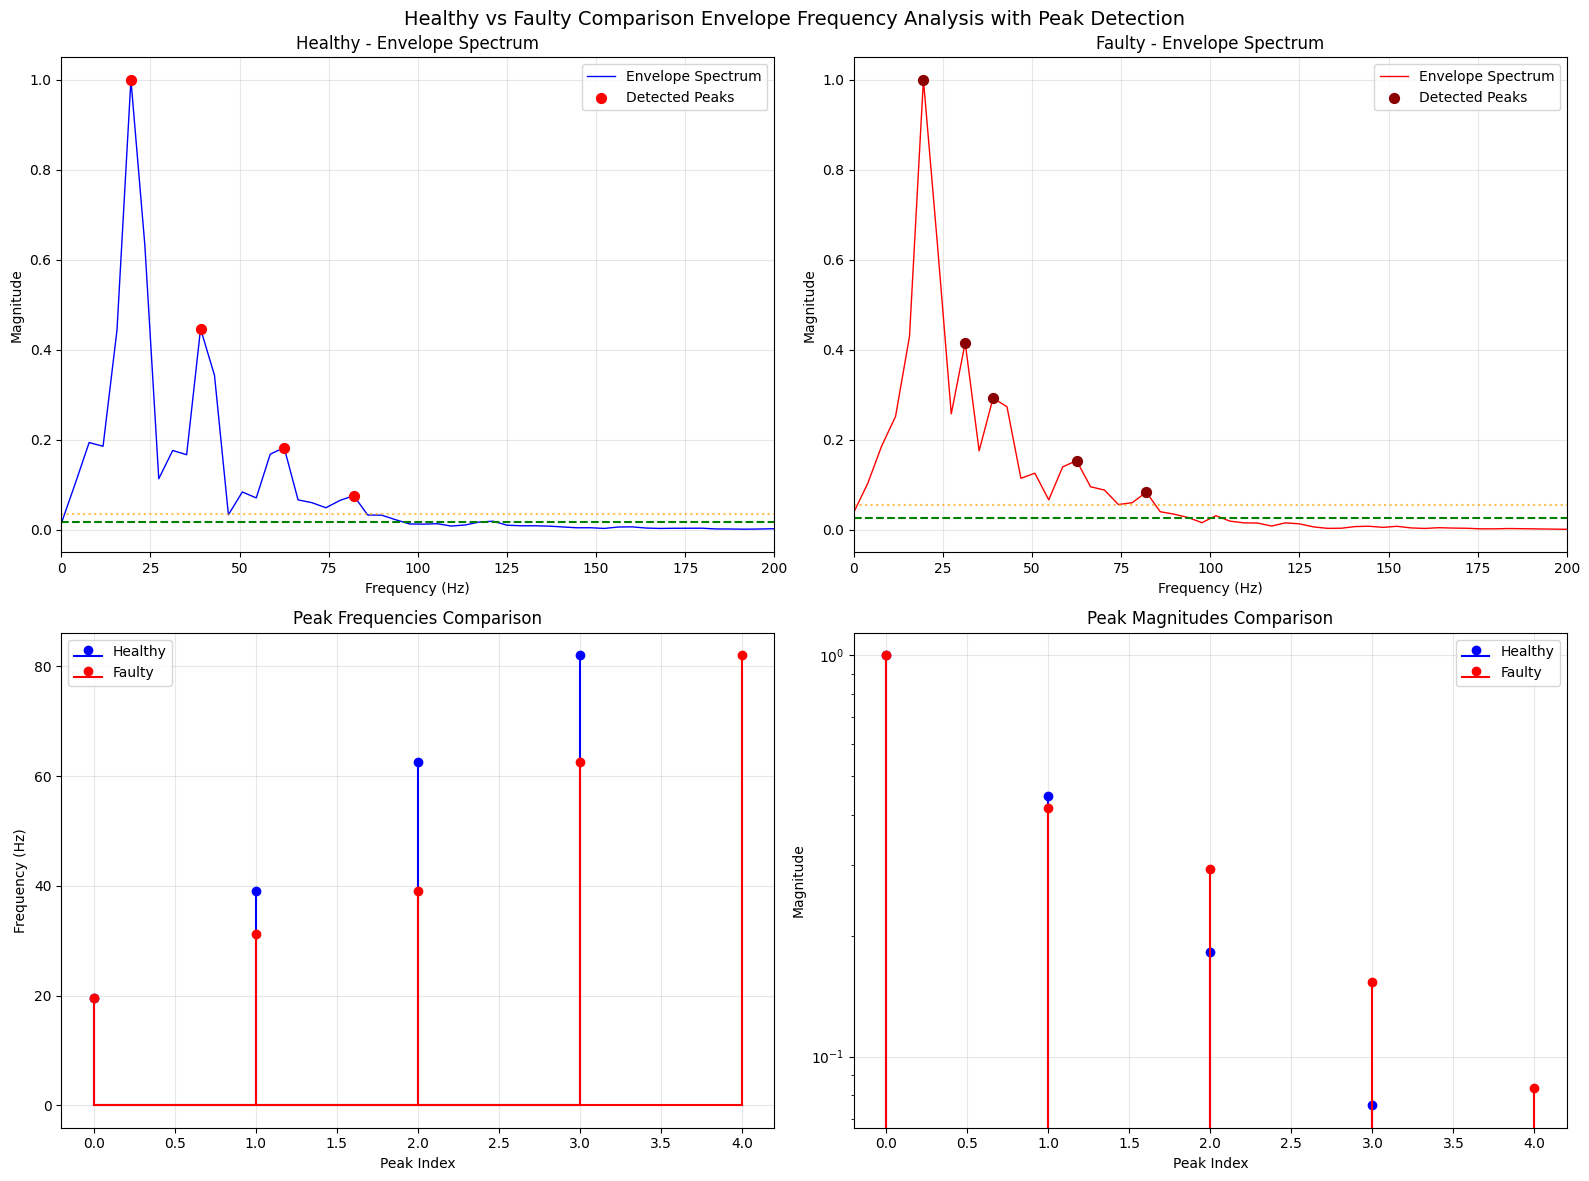


Healthy vs Faulty Comparison - Peak Analysis:

Healthy Envelope Peaks:
  Peak 1: 19.53 Hz, magnitude: 1.000000
  Peak 2: 39.06 Hz, magnitude: 0.446493
  Peak 3: 62.50 Hz, magnitude: 0.182706
  Peak 4: 82.03 Hz, magnitude: 0.075648

Faulty Envelope Peaks:
  Peak 1: 19.53 Hz, magnitude: 1.000000
  Peak 2: 31.25 Hz, magnitude: 0.415854
  Peak 3: 39.06 Hz, magnitude: 0.292707
  Peak 4: 62.50 Hz, magnitude: 0.153600
  Peak 5: 82.03 Hz, magnitude: 0.083576

Spectrum Statistics:
Healthy - Max magnitude: 1.000000, Mean: 0.019275
Faulty  - Max magnitude: 1.000000, Mean: 0.020854


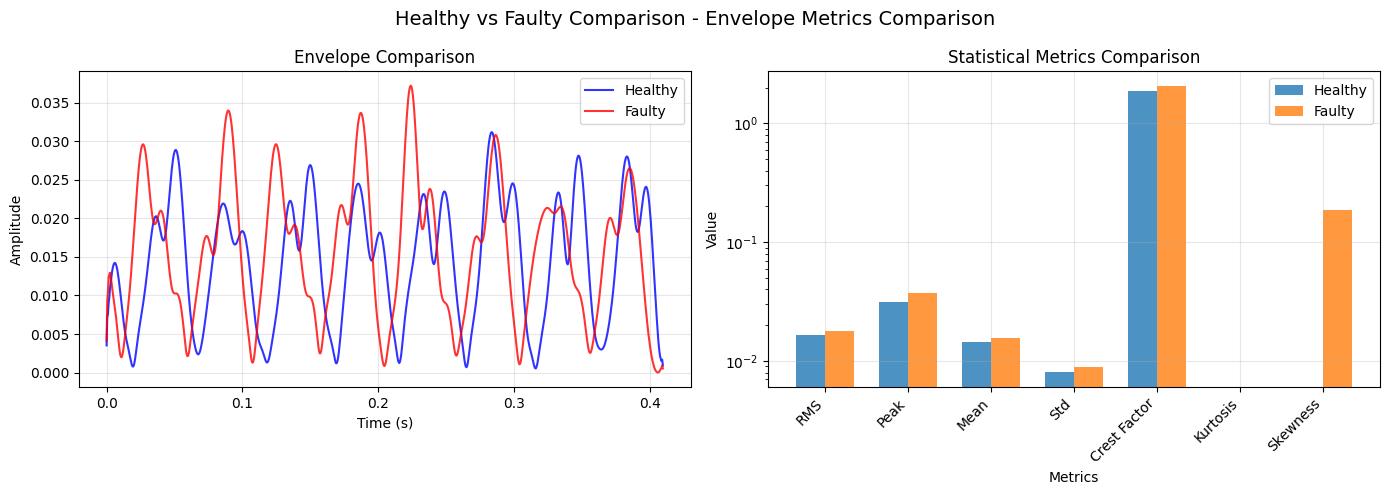

C:\Users\jkcvk\AppData\Local\Temp\ipykernel_10348\106292832.py:359: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[row, col].boxplot(data_to_plot, labels=['Healthy', 'Faulty'], patch_artist=True)
C:\Users\jkcvk\AppData\Local\Temp\ipykernel_10348\106292832.py:359: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[row, col].boxplot(data_to_plot, labels=['Healthy', 'Faulty'], patch_artist=True)
C:\Users\jkcvk\AppData\Local\Temp\ipykernel_10348\106292832.py:359: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[row, col].boxplot(data_to_plot, labels=['Healthy', 'Faulty'], patch_artis

In [ ]:
# Generate the comprehensive PDF report
import os
from datetime import datetime

# Create output directory if it doesn't exist
output_dir = "../notebooks/test_output"
os.makedirs(output_dir, exist_ok=True)

# Generate timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = os.path.join(output_dir, f"envelope_analysis_report_{timestamp}.pdf")

print("Starting PDF report generation...")
print(f"Number of healthy windows: {len(healthy_windows)}")
print(f"Number of faulty windows: {len(faulty_windows)}")
print(f"Output file: {output_filename}")

# Generate the report
try:
    report_path = create_comprehensive_pdf_report(
        healthy_windows=healthy_windows,
        faulty_windows=faulty_windows,
        analyzer=analyzer,
        config=env_conf,
        output_filename=output_filename
    )
    
    print(f"\nPDF report successfully generated!")
    print(f"Report saved as: {report_path}")
    print(f"File size: {os.path.getsize(report_path) / (1024*1024):.2f} MB")
    
    # Display some summary information
    print(f"\nReport Contents:")
    print(f"   • Title page with analysis parameters")
    print(f"   • Summary statistics comparing all windows")
    print(f"   • Individual analysis for {len(healthy_windows)} healthy windows")
    print(f"   • Individual analysis for {len(faulty_windows)} faulty windows") 
    print(f"   • Comparative analysis section")
    print(f"   • Total pages: ~{4 + len(healthy_windows) + len(faulty_windows)}")
    
except Exception as e:
    print(f"Error generating PDF report: {str(e)}")
    import traceback
    traceback.print_exc()